### Import Libraries

In [1]:
# Pandas
import pandas as pd

# Numpy
import numpy as np

# Datetime
import datetime

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# SciKit-Learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Keras from Tensorflow
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.models import load_model

# Time
import time

##**Introduction**

  Stock price prediction has long been an extremely challenging task. According to Shiller (2019), stock prices primarily fluctuate due to spontaneity, influenced by factors such as political events and investor confidence in companies. At the same time, economists and psychologists focused on behavioral finance have highlighted the bandwagon effect, which leads people to purchase more of a stock when they observe widespread buying. Moreover, investors typically underreact to new information unless the news has been established for some time (Malkiel, 2003). However, although it has always been controversial, the strong form of the efficient market hypothesis suggests that stock prices instantaneously incorporate all available information in the market and swiftly respond to new public data (Shah, Vaidya, and Shah, 2022). Nonetheless, historical stock data can still reveal valuable patterns that assist investors in making trading decisions.

  With the advancement of machine learning algorithms and artificial intelligence, various approaches have emerged for forecasting stock prices. These range from earlier statistics-based econometric methods like ARIMA to more complex deep learning networks such as Artificial Neural Networks (ANN), Convolutional Neural Networks (CNN), and Recurrent Neural Networks (RNN). A study indicated that the Long Short-Term Memory (LSTM) model outperforms other methods in predicting stock prices (Shah, Vaidya, and Shah, 2022). Thus, the following project demonstrates a complete workflow for forecasting day-ahead stock prices using the LSTM model, and also discusses some of its limitations.


### Data Acquisition

Datasets from two prominent global companies, Microsoft and Google, have been selected due to their significant overlap in business areas. By utilizing the Yahoo Finance API, precise historical data can be obtained. For this analysis, ten years of consecutive past data have been extracted for subsequent use.

In [2]:
import yfinance as yf

# Access to Microsoft and Google datasets
msft = yf.Ticker("MSFT")
googl = yf.Ticker("GOOGL")

# Define the start and end date
start_date = '2014-03-01'
end_date = '2024-03-01'

# Fetch the historical data for Google using the start and end dates
googl_hist = googl.history(start=start_date, end=end_date)

# Fetch the historical data for Microsoft using the same start and end dates
msft_hist = msft.history(start=start_date, end=end_date)

# Reference: https://github.com/ranaroussi/yfinance

#### Data structure

In [3]:
print("Google Historical Data:")
print(googl_hist.head())
print("Microsoft Historical Data:")
print(msft_hist.head())

Google Historical Data:
                                Open       High        Low      Close  \
Date                                                                    
2014-03-03 00:00:00-05:00  30.198950  30.226227  29.833332  30.097347   
2014-03-04 00:00:00-05:00  30.405405  30.430429  30.267769  30.403152   
2014-03-05 00:00:00-05:00  30.406656  30.607609  30.315565  30.486986   
2014-03-06 00:00:00-05:00  30.587587  30.684435  30.495495  30.520771   
2014-03-07 00:00:00-05:00  30.700701  30.705456  30.316317  30.400150   

                             Volume  Dividends  Stock Splits  
Date                                                          
2014-03-03 00:00:00-05:00  84107808        0.0           0.0  
2014-03-04 00:00:00-05:00  58649292        0.0           0.0  
2014-03-05 00:00:00-05:00  49362588        0.0           0.0  
2014-03-06 00:00:00-05:00  50673276        0.0           0.0  
2014-03-07 00:00:00-05:00  60543396        0.0           0.0  
Microsoft Historical Da

Upon examining the first five lines of the datasets for each stock, dates are used as indexes and seven columns are provided to give detailed stock information. These include 'Open', 'High', 'Low', 'Close' prices, stock 'Volume', dividends, and stock splits.

In [4]:
# General Info
msft_hist.info()
googl_hist.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2014-03-03 00:00:00-05:00 to 2024-02-29 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2517 non-null   float64
 1   High          2517 non-null   float64
 2   Low           2517 non-null   float64
 3   Close         2517 non-null   float64
 4   Volume        2517 non-null   int64  
 5   Dividends     2517 non-null   float64
 6   Stock Splits  2517 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 157.3 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2014-03-03 00:00:00-05:00 to 2024-02-29 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2517 non-null   float64
 1   High          2517 non-null   float64
 2   Low           2517 non-null   float64
 3   Close         2517 non-null   flo

The ```.info()``` method provides additional details about the datasets. The date indexes are formatted as DateTime. Moreover, all columns feature 2,517 non-null entries, which corresponds to the total number of entries. Therefore, no additional transformations or cleaning to address missing values are required.

The closing prices, which represent the last trading price of the day, are selected as the time series data for forecasting. This approach is also a common choice in much of the literature related to stock predictions using machine learning (Shah, Vaidya, and Shah, 2022).

In [5]:
# Create dataframes that only contains the 'Date' and 'Close' column
# Microsoft historical data are used here to train and test models
microsoft = msft_hist[['Close']]
google = googl_hist[['Close']]

### Exploratary Data Analysis

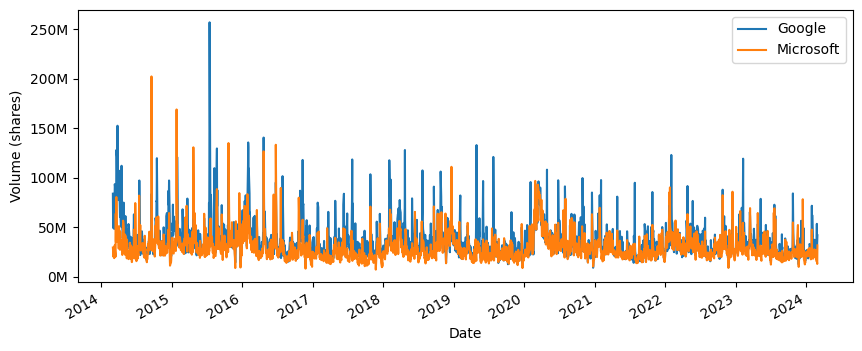

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def millions_formatter(x, pos):
    return f'{int(x / 1_000_000)}M'

# Plotting Google volume history
googl_hist['Volume'].plot(label='Google', legend=True, figsize=(10, 4))

# Plotting Microsoft volume history
msft_hist['Volume'].plot(label='Microsoft', legend=True, figsize=(10, 4))

# Setting the y-axis label
plt.ylabel('Volume (shares)')

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))

# Showing the plot with the legend
plt.legend()
plt.show()


By comparing the trading volumn across the past ten years, Google generally has higher trading activity compared to Microsoft. The peak trading volume occurred in 2016, exceeding 250 million transactions.

In [7]:
msft_hist.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,2517.000000,2517.000000,2517.000000,2517.000000,2.517000e+03,2517.000000,2517.0
mean,150.364584,151.852297,148.836118,150.421668,2.988039e+07,0.007668,0.0
std,106.202896,107.262707,105.110148,106.243330,1.377378e+07,0.062662,0.0
min,31.882204,32.187049,31.746725,31.924543,7.425600e+06,0.000000,0.0
25%,51.925143,52.232930,51.608307,51.979458,2.155250e+07,0.000000,0.0
50%,107.768774,108.448286,107.230670,107.938652,2.666030e+07,0.000000,0.0
75%,243.318597,246.059173,241.165673,243.937103,3.388560e+07,0.000000,0.0
max,419.783705,420.043233,414.323799,419.773712,2.025224e+08,0.750000,0.0


 From the table provided above, it is evident that there is a significant disparity between the minimum and maximum closing prices of Microsoft stock. Specifically, the maximum closing price was 13.15 times higher than the minimum. This gap is larger than that of Google, where the maximum closing price was only 6.18 times the minimum. Interestingly, for both companies, the maximum closing price occurred in 2014, while the minimum closing price appeared in current year 2024.


In [8]:
# Find the maximum and minimum closing prices
max_price_msft = microsoft['Close'].max()
min_price_msft = microsoft['Close'].min()

# Find the dates for the maximum and minimum closing prices
max_price_date_msft = microsoft[microsoft['Close'] == max_price_msft].index[0]
min_price_date_msft = microsoft[microsoft['Close'] == min_price_msft].index[0]


print(f"The maximum closing price was ${max_price_msft:.2f} on {max_price_date_msft.strftime('%Y-%m-%d')}")
print(f"The minimum closing price was ${min_price_msft:.2f} on {min_price_date_msft.strftime('%Y-%m-%d')}")

msft_times = max_price_msft / min_price_msft
print(f"The maximum closing price was {msft_times:.2f} times greater than the minimum closing price.")

The maximum closing price was $419.77 on 2024-02-09
The minimum closing price was $31.92 on 2014-03-14
The maximum closing price was 13.15 times greater than the minimum closing price.


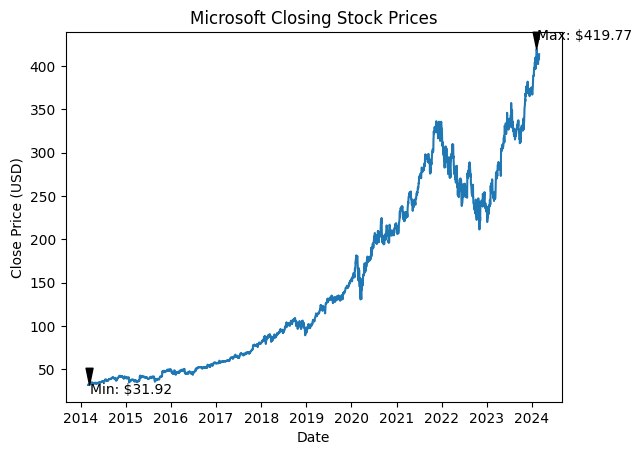

In [9]:
import matplotlib.pyplot as plt

plt.plot(microsoft.index, microsoft['Close'])
plt.title('Microsoft Closing Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.annotate(f'Max: ${max_price_msft:.2f}', xy=(max_price_date_msft, max_price_msft), xytext=(max_price_date_msft, max_price_msft+10),
             arrowprops=dict(facecolor='black', shrink=1, width=1, headwidth=5))
plt.annotate(f'Min: ${min_price_msft:.2f}', xy=(min_price_date_msft, min_price_msft), xytext=(min_price_date_msft, min_price_msft-10),
             arrowprops=dict(facecolor='black', shrink=1, width=1, headwidth=5))
plt.show()

In [10]:
# Find the maximum and minimum closing prices
max_price_googl = google['Close'].max()
min_price_googl = google['Close'].min()

# Find the dates for the maximum and minimum closing prices
max_price_date_googl = google[google['Close'] == max_price_googl].index[0]
min_price_date_googl = google[google['Close'] == min_price_googl].index[0]


print(f"The maximum closing price was ${max_price_googl:.2f} on {max_price_date_googl.strftime('%Y-%m-%d')}")
print(f"The minimum closing price was ${min_price_googl:.2f} on {min_price_date_googl.strftime('%Y-%m-%d')}")

googl_times = max_price_googl / min_price_googl
print(f"The maximum closing price was {googl_times:.2f} times greater than the minimum closing price.")

The maximum closing price was $153.51 on 2024-01-29
The minimum closing price was $24.85 on 2015-01-12
The maximum closing price was 6.18 times greater than the minimum closing price.


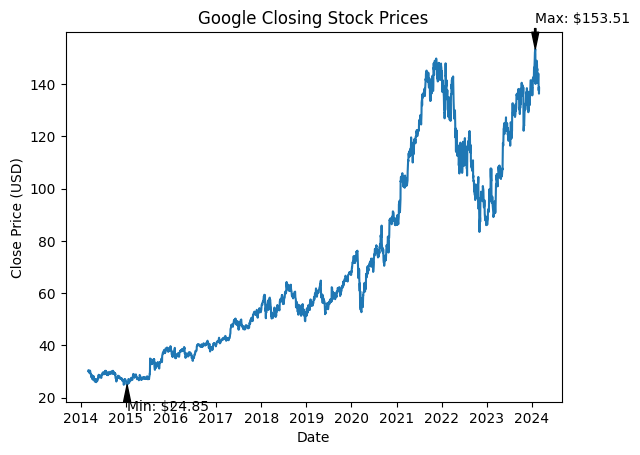

In [11]:
plt.plot(google.index, google['Close'])
plt.title('Google Closing Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.annotate(f'Max: ${max_price_googl:.2f}', xy=(max_price_date_googl, max_price_googl), xytext=(max_price_date_googl, max_price_googl+10),
             arrowprops=dict(facecolor='black', shrink=1, width=1, headwidth=5))
plt.annotate(f'Min: ${min_price_googl:.2f}', xy=(min_price_date_googl, min_price_googl), xytext=(min_price_date_googl, min_price_googl-10),
             arrowprops=dict(facecolor='black', shrink=1, width=1, headwidth=5))
plt.show()

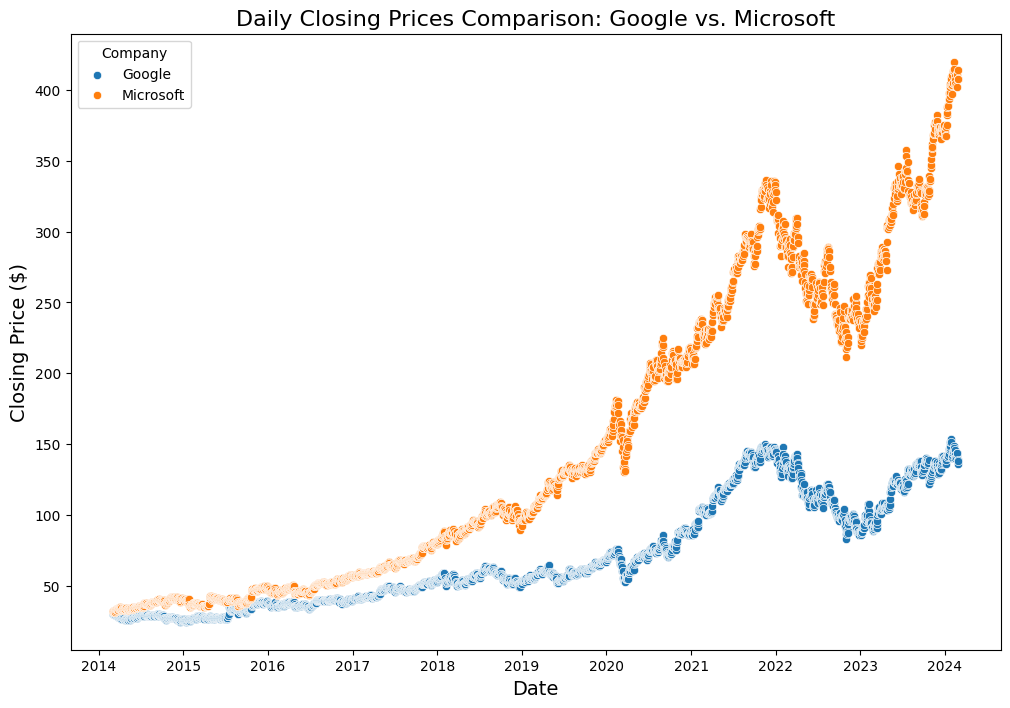

In [12]:
# Compare the daily stock closing prices
plt.figure(figsize=(12, 8))
plt.title('Daily Closing Prices Comparison: Google vs. Microsoft', fontsize=16)

# Plotting Google's closing prices
sns.scatterplot(x=google.index, y=google['Close'], label='Google')

# Plotting Microsoft's closing prices
sns.scatterplot(x=microsoft.index, y=microsoft['Close'], label='Microsoft')

# Setting the labels with updated font sizes
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price ($)', fontsize=14)

# Show legend with a title
plt.legend(title='Company')

# Show the plot
plt.show()

The 'Daily Closing Price Comparison' plot shows that the two stocks generally follow similar trends, although Microsoft's closing prices are higher at most time points. In the most recent year, the closing price of a single share of Microsoft was more than twice that of Google's stock.

It is also noteworthy that there were two significant declines in stock prices from the end of 2021 to the end of 2022. These downturns may be attributed to the global pandemic and its consequent economic recession.

### Data Preprocessing:

#### Feature Scaling

From the previous exploratory data analysis, it's clear that the maximum and minimum closing prices for both stocks vary significantly. Consequently, Min-Max scaling is employed as a normalization technique to mitigate the overshadowing effect caused by these differences in magnitude (Bhandari, 2020).

The decision to use Min-Max scaling is supported by research from Prasetya Wibawa et al. (2024), which found that a Bidirectional Long Short-Term Memory model employing this normalization technique surpasses the performance of models that use Z-score normalization.

In [13]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

close_prices = microsoft['Close'].values.reshape(-1, 1)
sc = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = sc.fit_transform(close_prices)

#### Transformation

Here, the function ```create_lstm_data()``` is designed to prepare data suitable for LSTM input by transforming time series data into sequences. The term ```time-steps``` refers to the number of time intervals considered for each input.

This project aims to forecast day-ahead stock prices. Drawing on findings from Shen and Shafiq (2020), a span of 10 trading days (approximately two weeks) is defined as the length for each sequence. This window is strategically chosen to encompass several business days, thereby integrating a range of market or environmental conditions into the model's learning process.

In [14]:
# Convert an array of values into a dataset matrix
# Reshape into X=t and Y=t+1
def create_lstm_data(data, time_steps=1):
 x, y = [], []
 for i in range(len(data) - time_steps):
  x.append(data[i:(i + time_steps), 0])
  y.append(data[i + time_steps, 0])
 return np.array(x), np.array(y)

In [15]:
# Setting Time Steps and Creating Input Data:
import numpy as np

time_steps = 10 # 2 weeks of work day
x,y = create_lstm_data(close_prices_scaled, time_steps)

# reshape input to be [samples, time steps, features]
x = np.reshape(x, (x.shape[0], 1, x.shape[1]))

### Split of Train,Validation and Test Set

The 'Microsoft' dataset is split into 50% for training, 25% for validation, and 25% for testing. This might not be a perfect split but a starting point to train and test the model.

In [16]:
# Calculate the indices for the splits
n = len(x)
train_size = int(n * 0.5)  # 50% for training
val_size = int(n * 0.25)  # 25% for validation
test_size = n - train_size - val_size  # 25% for testing, this should be equivalent to val_size

# Split the data sequentially
x_train = x[:train_size]
y_train = y[:train_size]

x_val = x[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

x_test = x[train_size + val_size:]
y_test = y[train_size + val_size:]

# Training set: x_train, y_train (50% of the data)
# Validation set: x_val, y_val (25% of the data)
# Testing set: x_test, y_test (25% of the data)


### First LSTM Model

In each LSTM layer, the 'tanh' activation function is used for the cell output, while the 'sigmoid' activation function is used for the recurrent gates. Compared to traditional RNNs, LSTMs address the issues of vanishing and exploding gradients by incorporating a series of gates that regulate the flow of information. These gates adeptly control how much information is preserved or discarded as it progresses through the network(J, 2021).

The number of neurons in each layer and the dropout rate are carefully selected based on the study by Gülmez (2023), which offers a comprehensive examination of the parameters utilized in their research. Additionally, the Adam optimizer is chosen for its effectiveness in stock price forecasting with LSTM networks, as highlighted in the research by Wang et al. (2021). This optimizer is known for its ability to adaptively adjust learning rates, making it particularly suitable for handling the complexities of financial time series data. Employing these settings, the model established here is intended to serve as a robust baseline for further explorations and enhancements in predicting stock prices.

In [17]:
# Build the Model
model_1 = Sequential()
model_1.add(LSTM(20, return_sequences=True, input_shape=(1, time_steps)))
model_1.add(LSTM(10, return_sequences=False))
model_1.add(Dense(10))
model_1.add(Dropout(0.5))
model_1.add(Dense(1))
model_1.compile(optimizer='adam', loss='mean_squared_error')


In [18]:
# Start the timer
start_time = time.time()

# Train the model
history_1 = model_1.fit(x_train, y_train,validation_data = (x_val,y_val), epochs=50, batch_size=8)

# Stop the timer
end_time = time.time()

# Calculate the duration
training_time = end_time - start_time

# Print the training time
print(f"Model training took {training_time:.2f} seconds.")

Epoch 1/50
157/157 [==============================] - 14s 12ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 2/50
157/157 [==============================] - 1s 9ms/step - loss: 5.8606e-04 - val_loss: 0.0017
Epoch 3/50
157/157 [==============================] - 1s 8ms/step - loss: 4.6084e-04 - val_loss: 0.0019
Epoch 4/50
157/157 [==============================] - 1s 5ms/step - loss: 3.5515e-04 - val_loss: 5.8440e-04
Epoch 5/50
157/157 [==============================] - 1s 5ms/step - loss: 3.6259e-04 - val_loss: 5.0571e-04
Epoch 6/50
157/157 [==============================] - 1s 5ms/step - loss: 3.9533e-04 - val_loss: 2.8979e-04
Epoch 7/50
157/157 [==============================] - 1s 5ms/step - loss: 3.6753e-04 - val_loss: 3.1083e-04
Epoch 8/50
157/157 [==============================] - 1s 5ms/step - loss: 3.4637e-04 - val_loss: 0.0010
Epoch 9/50
157/157 [==============================] - 1s 5ms/step - loss: 3.3451e-04 - val_loss: 0.0036
Epoch 10/50
157/157 [=============================

In [19]:
# Save the model
model_1.save('lstm_model_1.h5')
print("Model saved successfully!")

# Load the model
model_1 = load_model('lstm_model_1.h5')

Model saved successfully!


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


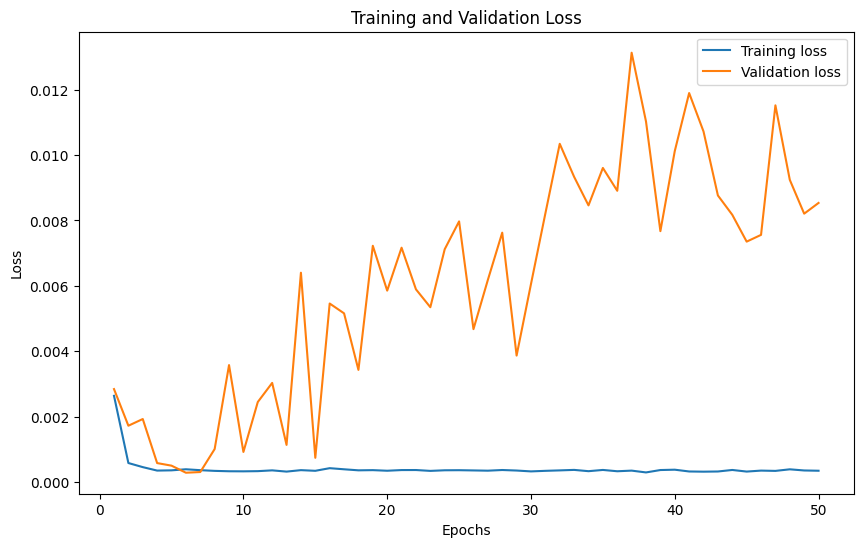

In [20]:
training_loss = history_1.history['loss']
validation_loss = history_1.history['val_loss']

epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, validation_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Upon examination of the training and validation loss graph, it is clear that the validation loss increases with the number of epochs, suggesting a potential overfitting problem. Even though a dropout layer has been added, this issue may persist. Implementing other regularization methods could be beneficial.

In [21]:
train_predict_1 = model_1.predict(x_train)
val_predict_1 = model_1.predict(x_val)

# transform to original form
train_predict_1 = sc.inverse_transform(train_predict_1).flatten()
val_predict_1 = sc.inverse_transform(val_predict_1).flatten()

20/20 [==============================] - 0s 3ms/step


In [22]:
# Generate the actual indices for each dataset
train_indices = microsoft.index[:train_size]
val_indices = microsoft.index[train_size:train_size + val_size]
# Get the last 'test_size' rows of the 'microsoft' DataFrame
last_rows = microsoft.tail(test_size)
# Get the indices of these rows
test_indices = last_rows.index

In [23]:
# Assuming 'y' contains the scaled output values you want to convert back
y_train_original = sc.inverse_transform(y_train.reshape(-1, 1))
y_val_original = sc.inverse_transform(y_val.reshape(-1, 1))
y_test_original = sc.inverse_transform(y_test.reshape(-1, 1))

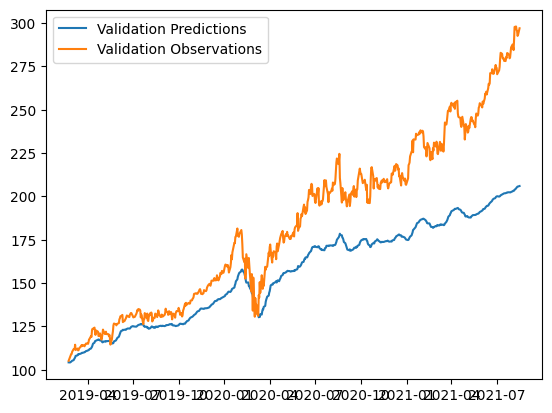

In [24]:
plt.plot(val_indices, val_predict_1)
plt.plot(val_indices, y_val_original)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [25]:
test_predict_1 = model_1.predict(x_test)
# transform to original form
test_predict_1 = sc.inverse_transform(test_predict_1).flatten()

20/20 [==============================] - 0s 2ms/step


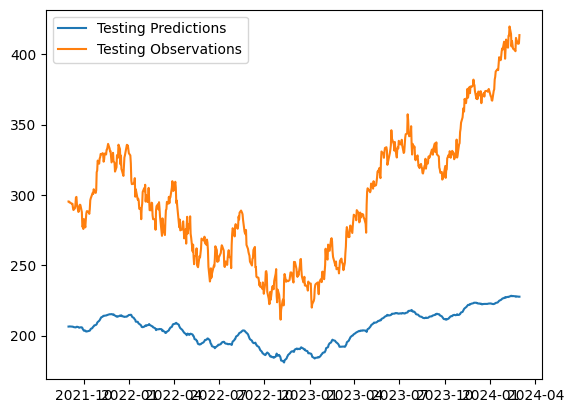

In [26]:
plt.plot(test_indices, test_predict_1)
plt.plot(test_indices, y_test_original)
plt.legend(['Testing Predictions', 'Testing Observations'])

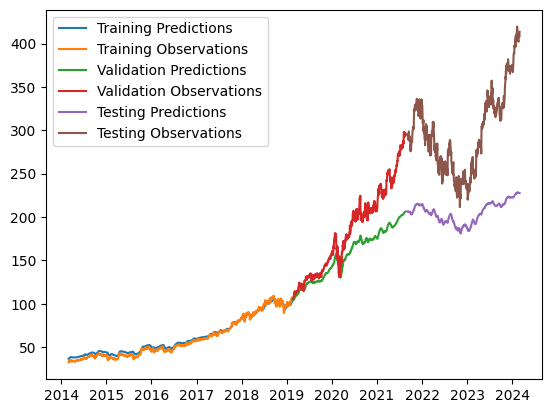

In [27]:
plt.plot(train_indices, train_predict_1)
plt.plot(train_indices, y_train_original)
plt.plot(val_indices, val_predict_1)
plt.plot(val_indices, y_val_original)
plt.plot(test_indices, test_predict_1)
plt.plot(test_indices, y_test_original)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [28]:
# Assuming y_true contains the actual values and y_pred contains the predicted values
mse = mean_squared_error(y_test_original, test_predict_1)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test_original, test_predict_1)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)


MSE: 9940.971148927802
RMSE: 99.7044189037166
MAE: 93.1995793725275


MSE (Mean Squared Error) is a commonly used metric to assess the performance of a regression task, penalizing larger prediction errors more severely because it involves squaring the errors. Conversely, RMSE (Root Mean Squared Error) brings the error metrics back to the original unit by taking the square root of the MSE, making it less sensitive to large errors compared to MSE (Trevisan, 2022). MAE (Mean Absolute Error), on the other hand, is less influenced by outliers than both MSE and RMSE. Since MAE is calculated using absolute differences, it measures the average magnitude of the errors in the predictions(M, 2021).

The RMSE and MAE show minimal differences, which, when combined with previous graphical analyses, suggest that both overfitting and underfitting issues may be present in the current model. Specifically, the model's performance deteriorates on the validation and test sets as time progresses, particularly after the training period (post-2019). This decline indicates that while the model may fit earlier data well, it struggles to generalize to new, unseen data, highlighting potential weaknesses in its predictive capabilities over time.

### Second LSTM Model

The second model incorporates an additional LSTM layer, maintaining the same number of neurons as the existing second layer, to explore whether this adjustment enhances performance. All other parameters remain consistent with those of the previous model.

In [29]:
model_2 = Sequential()
model_2.add(LSTM(20, return_sequences=True, input_shape=(1,time_steps)))
model_2.add(LSTM(10, return_sequences=True))
model_2.add(LSTM(10,return_sequences=False))
model_2.add(Dense(10))
model_2.add(Dropout(0.5))
model_2.add(Dense(1))
model_2.compile(optimizer='adam', loss='mean_squared_error')

In [30]:
# Start the timer
start_time = time.time()

# Train the model
history_2 = model_2.fit(x_train, y_train,validation_data = (x_val,y_val), epochs=50, batch_size=8)

# Stop the timer
end_time = time.time()

# Calculate the duration
training_time = end_time - start_time

# Print the training time
print(f"Model training took {training_time:.2f} seconds.")

Epoch 1/50
157/157 [==============================] - 9s 15ms/step - loss: 0.0029 - val_loss: 3.0876e-04
Epoch 2/50
157/157 [==============================] - 1s 8ms/step - loss: 6.8194e-04 - val_loss: 0.0011
Epoch 3/50
157/157 [==============================] - 1s 8ms/step - loss: 5.2032e-04 - val_loss: 7.1694e-04
Epoch 4/50
157/157 [==============================] - 1s 7ms/step - loss: 4.1549e-04 - val_loss: 0.0024
Epoch 5/50
157/157 [==============================] - 1s 8ms/step - loss: 4.2034e-04 - val_loss: 5.5857e-04
Epoch 6/50
157/157 [==============================] - 1s 9ms/step - loss: 3.9866e-04 - val_loss: 0.0014
Epoch 7/50
157/157 [==============================] - 2s 10ms/step - loss: 3.5245e-04 - val_loss: 0.0016
Epoch 8/50
157/157 [==============================] - 1s 7ms/step - loss: 3.6126e-04 - val_loss: 0.0026
Epoch 9/50
157/157 [==============================] - 1s 8ms/step - loss: 3.4306e-04 - val_loss: 0.0024
Epoch 10/50
157/157 [==============================] -

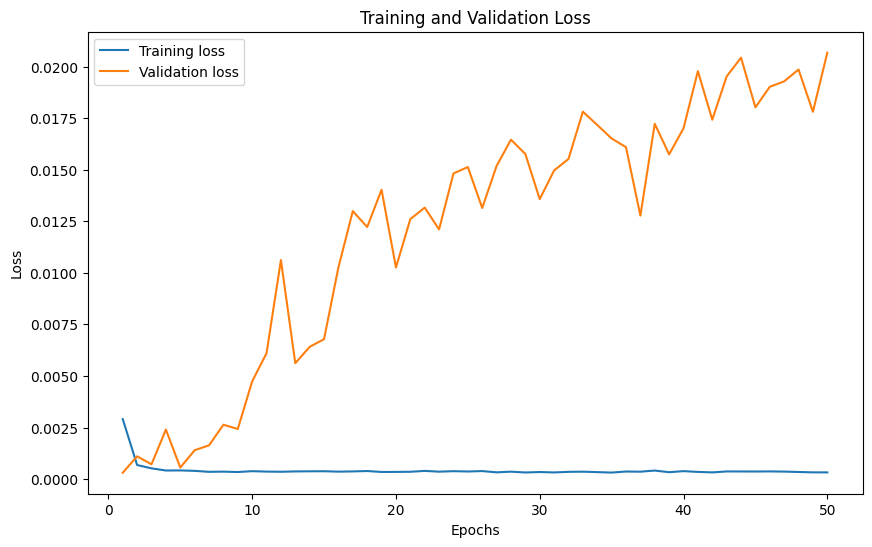

In [31]:
training_loss = history_2.history['loss']
validation_loss = history_2.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, validation_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

As expected, the validation loss continues to increase as the number of epochs grows, given that no additional regularization techniques have been applied. It still learns the details and noise in the training data to an extent that it negatively impacts the performance on new data, as reflected in the increasing validation loss.

In [32]:
# Save the model
model_2.save('lstm_model_2.h5')  # creates a HDF5 file 'my_model.h5'
print("Model saved successfully!")

# Load the model
model_2 = load_model('lstm_model_2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully!


In [33]:
train_predict_2 = model_2.predict(x_train)
val_predict_2 = model_2.predict(x_val)

# transform to original form
train_predict_2 = sc.inverse_transform(train_predict_2).flatten()
val_predict_2 = sc.inverse_transform(val_predict_2).flatten()

20/20 [==============================] - 0s 3ms/step


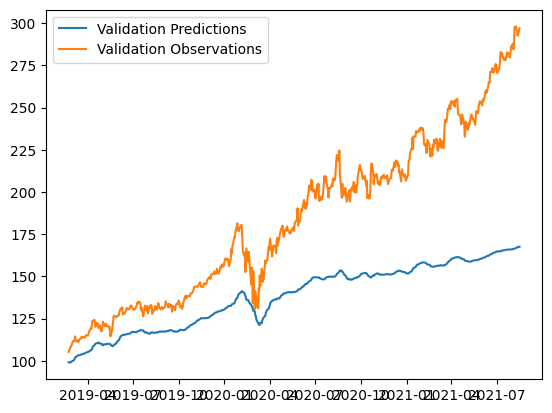

In [34]:
plt.plot(val_indices, val_predict_2)
plt.plot(val_indices, y_val_original)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [35]:
test_predict_2 = model_2.predict(x_test)
# transform to original form
test_predict_2 = sc.inverse_transform(test_predict_2).flatten()

20/20 [==============================] - 0s 2ms/step


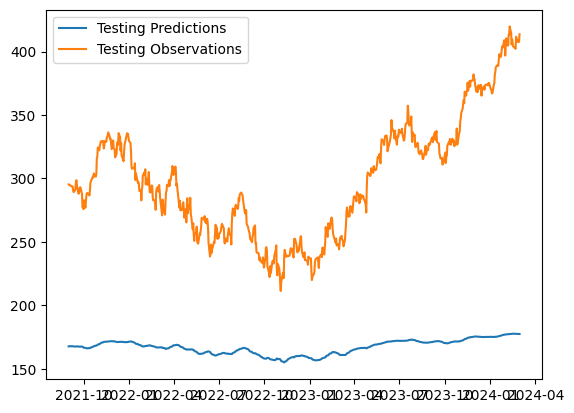

In [36]:
plt.plot(test_indices, test_predict_2)
plt.plot(test_indices, y_test_original)
plt.legend(['Testing Predictions', 'Testing Observations'])

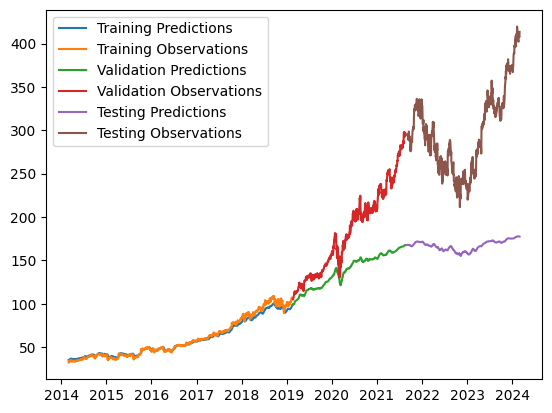

In [54]:
plt.plot(train_indices, train_predict_2)
plt.plot(train_indices, y_train_original)
plt.plot(val_indices, val_predict_2)
plt.plot(val_indices, y_val_original)
plt.plot(test_indices, test_predict_2)
plt.plot(test_indices, y_test_original)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [37]:
# Assuming y_true contains the actual values and y_pred contains the predicted values
mse = mean_squared_error(y_test_original, test_predict_2)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test_original, test_predict_2)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)


MSE: 18994.12224751994
RMSE: 137.81916502257565
MAE: 131.44176439418914


The RMSE and MAE values, which are even higher than those from the first model (RMSE: 99.70, MAE: 93.20), indicate that adding an extra LSTM layer did not improve the model's performance. This outcome suggests that for this particular model, adjusting the number of neurons and applying regularization techniques might be more crucial than merely increasing the model's complexity through additional layers. These adjustments could potentially address overfitting issues and improve the model's ability to generalize to new data.

### Hyperparameter optimization using KerasTuner


Following the insights gained from previous evaluations, Keras Tuner has been utilized to explore models with various hyperparameter settings (Pedregosa et al., 2011). Due to computational resource constraints, the Tuner adjusts the number of neurons in the first LSTM layer between 10 and 50 units in increments of 10, and between 10 and 30 units in the second LSTM layer. It also tests different dropout rates from 0.1 to 0.5 to determine the optimal balance for preventing overfitting. To efficiently navigate the search space within limited computational time, a random search approach is employed (Bergstra, Ca, and Ca, 2012). Finally, Early stopping is integrated into the process as well to curtail training if the model ceases to improve, thereby further reducing the risk of overfitting.

This automated hyperparameter tuning process significantly streamlines the experimentation phase, reducing manual iterations and efficiently pinpointing the most effective model configurations. The best-performing model selected through this method will subsequently be retrained and tested on the 'Microsoft' dataset, ensuring its robustness and accuracy in forecasting stock prices.

In [38]:
!pip install keras-tuner

# Import necessary libraries
from tensorflow import keras
from keras_tuner import HyperModel, RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define the LSTMHyperModel class
class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential([
            LSTM(
                hp.Int('units_1', min_value=10, max_value=50, step=10),
                return_sequences=True,
                input_shape=self.input_shape
            ),
            LSTM(
                hp.Int('units_2', min_value=10, max_value=30, step=10),
                return_sequences=False  # Changed to False for the final LSTM layer to flatten the output
            ),
            Dense(10),
            Dropout(
                hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)  # Tuner chooses dropout between 0.1 and 0.5
            ),
            Dense(1)  # Output layer with a single unit for regression output
        ])
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
        return model

# Specify the input shape
input_shape = (1, time_steps)  # Ensure 'time_steps' is defined somewhere in your code

# Configure and create the tuner
tuner = RandomSearch(
    LSTMHyperModel(input_shape=input_shape),
    objective='val_loss',
    max_trials=3,
    executions_per_trial=3,
    directory='tuner_results',
    project_name='lstm_tuning'
)

# Assuming x_train, y_train, x_val, and y_val are defined
# Search for the best model configuration
tuner.search(x_train, y_train, validation_data=(x_val, y_val), epochs=50,
             callbacks=[EarlyStopping(monitor='val_loss', patience=20)])


Trial 3 Complete [00h 01m 03s]
val_loss: 0.00020872030290775

Best val_loss So Far: 0.00019069277914240956
Total elapsed time: 00h 03m 13s


In [40]:
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Retrieve the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Model Summary:")
best_model.summary()

# Print the best hyperparameters
print("Best Hyperparameters:")
for param, value in best_hyperparameters.values.items():
    print(f"{param}: {value}")

Best Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             12200     
                                                                 
 lstm_1 (LSTM)               (None, 20)                5680      
                                                                 
 dense (Dense)               (None, 10)                210       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 18101 (70.71 KB)
Trainable params: 18101 (70.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


As the above table shows, the best model includes two LSTM layers with 50 and 20 units respectively. It also includes a dropout layer with a 10% rate to prevent overfitting and two dense layers for transforming LSTM outputs into a final prediction.

In [41]:
# Start the timer
start_time = time.time()

# Train the model
history_3 = best_model.fit(x_train, y_train,validation_data = (x_val,y_val), epochs=50, batch_size=8)

# Stop the timer
end_time = time.time()

# Calculate the duration
training_time = end_time - start_time

# Print the training time
print(f"Model training took {training_time:.2f} seconds.")

Epoch 1/50
157/157 [==============================] - 45s 79ms/step - loss: 8.4856e-05 - mse: 8.4856e-05 - val_loss: 2.4604e-04 - val_mse: 2.4604e-04
Epoch 2/50
157/157 [==============================] - 2s 13ms/step - loss: 7.4163e-05 - mse: 7.4163e-05 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 3/50
157/157 [==============================] - 4s 23ms/step - loss: 7.7382e-05 - mse: 7.7382e-05 - val_loss: 5.9418e-04 - val_mse: 5.9418e-04
Epoch 4/50
157/157 [==============================] - 3s 19ms/step - loss: 6.2581e-05 - mse: 6.2581e-05 - val_loss: 3.9339e-04 - val_mse: 3.9339e-04
Epoch 5/50
157/157 [==============================] - 2s 10ms/step - loss: 6.7885e-05 - mse: 6.7885e-05 - val_loss: 3.2076e-04 - val_mse: 3.2076e-04
Epoch 6/50
157/157 [==============================] - 2s 14ms/step - loss: 6.3836e-05 - mse: 6.3836e-05 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 7/50
157/157 [==============================] - 2s 12ms/step - loss: 6.0086e-05 - mse: 6.0086e-05 - val_loss: 0.001

In [42]:
# Save the model
best_model.save('lstm_model_3.h5')
print("Model saved successfully!")

# Load the model
best_model = load_model('lstm_model_3.h5')

Model saved successfully!


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


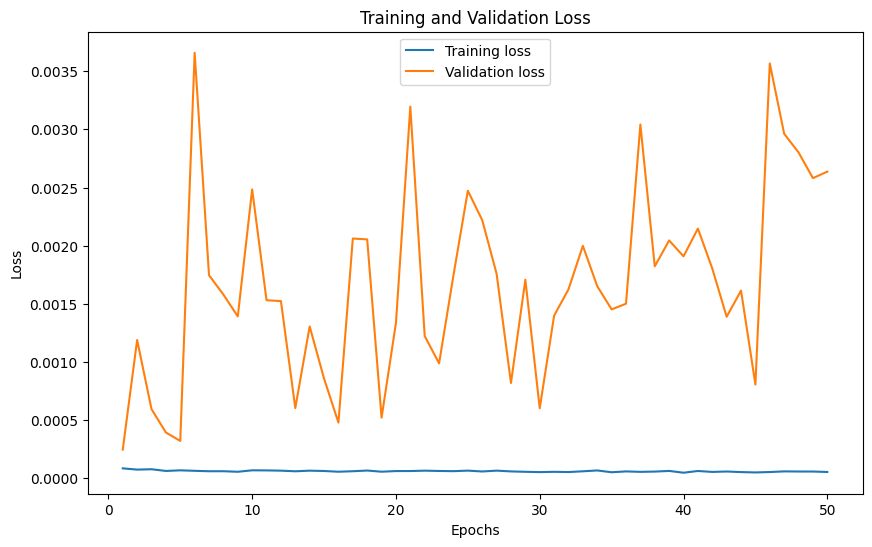

In [43]:
training_loss = history_3.history['loss']
validation_loss = history_3.history['val_loss']

epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, validation_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Now, despite some fluctuations, the validation loss exhibits significantly smaller values compared to the previous models (with the highest validation loss surpassing 0.012 for the first model and 0.020 for the second model). This improvement suggests that the model has the potential to better generalize and make accurate predictions for unseen datasets compared to the previous two models.

In [44]:
train_predict_3 = best_model.predict(x_train)
val_predict_3 = best_model.predict(x_val)

# transform to original form
train_predict_3 = sc.inverse_transform(train_predict_3).flatten()
val_predict_3 = sc.inverse_transform(val_predict_3).flatten()

20/20 [==============================] - 0s 4ms/step


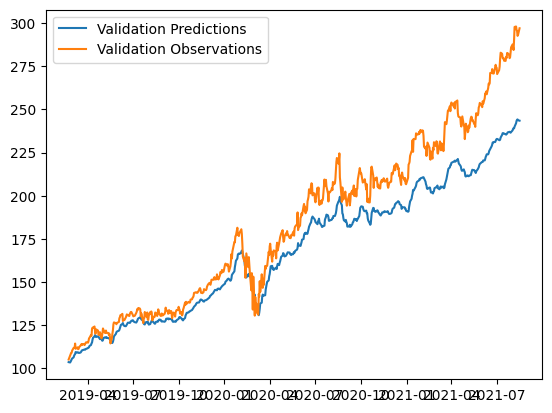

In [45]:
plt.plot(val_indices, val_predict_3)
plt.plot(val_indices, y_val_original)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [46]:
test_predict_3 = best_model.predict(x_test)
# transform to original form
test_predict_3 = sc.inverse_transform(test_predict_3).flatten()

20/20 [==============================] - 0s 2ms/step


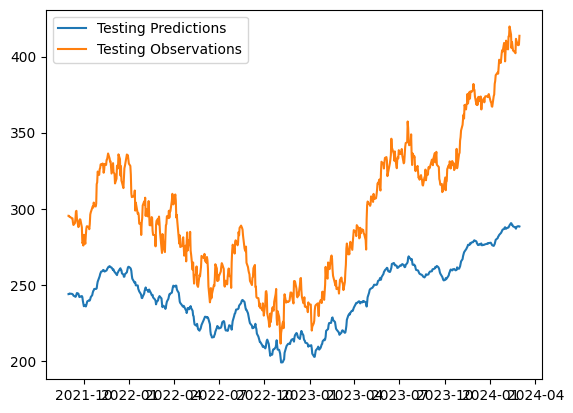

In [47]:
plt.plot(test_indices, test_predict_3)
plt.plot(test_indices, y_test_original)
plt.legend(['Testing Predictions', 'Testing Observations'])

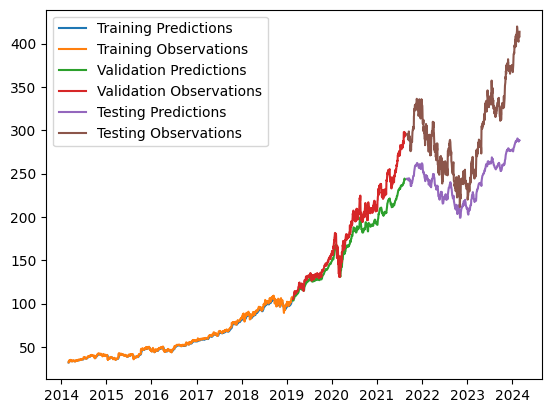

In [55]:
plt.plot(train_indices, train_predict_3)
plt.plot(train_indices, y_train_original)
plt.plot(val_indices, val_predict_3)
plt.plot(val_indices, y_val_original)
plt.plot(test_indices, test_predict_3)
plt.plot(test_indices, y_test_original)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [48]:
# Assuming y_true contains the actual values and y_pred contains the predicted values
mse = mean_squared_error(y_test_original, test_predict_3)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test_original, test_predict_3)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)


MSE: 3691.809113136735
RMSE: 60.760259324139945
MAE: 55.31016705749901


Comparing the MSE, RMSE, and MAE values to previous results, the errors are significantly reduced. Even though the model may still underpredict days with very high stock prices, overall performance has notably improved compared to the first two models.

Thus, rather than increasing model complexity by adding extra LSTM layers, it appears more effective to augment the number of neurons in the first LSTM layer. Additionally, research suggests that adding more LSTM layers beyond three does not necessarily enhance model performance (Zhang et al., 2018). This underscores the importance of optimizing model architecture by focusing on the appropriate number of neurons and layers to achieve optimal forecasting accuracy.

### Testing with new dataset (Google stock prices)

Now, the 'Google' dataset is utilized as a new dataset to evaluate the final best model. The data preprocessing follows the same steps as previously conducted for the 'Microsoft' dataset.

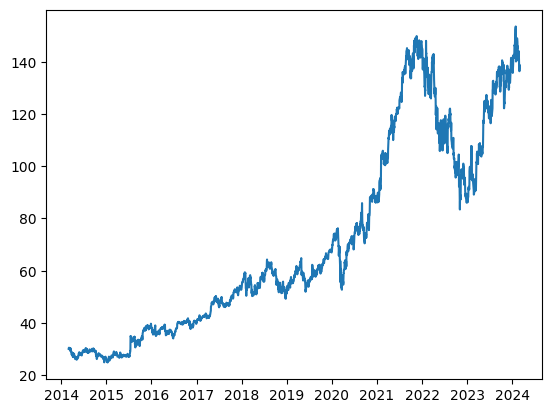

In [49]:
plt.plot(google)

In [50]:
stock_price_goog = google['Close'].values.reshape(-1, 1)
stock_price_goog_scaled = sc.fit_transform(stock_price_goog)

x_goog,y_goog = create_lstm_data(stock_price_goog_scaled, time_steps)
x_goog = np.reshape(x_goog, (x_goog.shape[0], 1,x_goog.shape[1]))

In [51]:
test_goog = best_model.predict(x_goog)
# transform to original form
pred_goog = sc.inverse_transform(test_goog).flatten()
goog_test_original = sc.inverse_transform(y_goog.reshape(-1, 1))

79/79 [==============================] - 1s 6ms/step


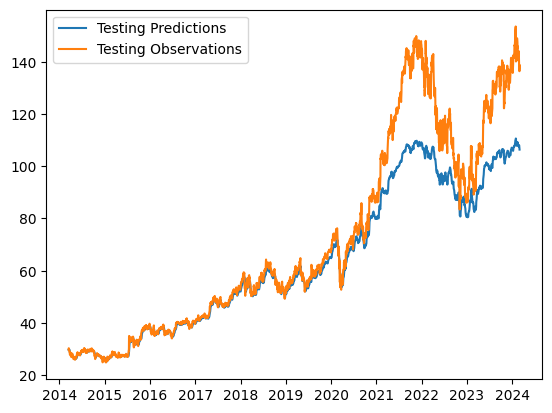

In [52]:
plt.plot(google.index[10:], pred_goog)
plt.plot(google.index[10:], goog_test_original)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [53]:
# Assuming y_true contains the actual values and y_pred contains the predicted values
mse = mean_squared_error(goog_test_original, pred_goog)
rmse = mse ** 0.5
mae = mean_absolute_error(goog_test_original, pred_goog)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)

MSE: 191.13013775570943
RMSE: 13.824982378133775
MAE: 8.08846016523607


Utilizing the complete historical stock data spanning the past 10 years appears to significantly enhance the model's performance, as evidenced by the dramatic decrease in RMSE and MAE to single-digit values. Several factors may account for this improvement. Firstly, with a larger dataset, the model is better equipped to capture a broader range of information, which can lead to more accurate predictions. Secondly, it is noteworthy that Google's stock prices are generally lower than those of Microsoft after 2019, as indicated by the exploratory data analysis results. Consequently, the MSE, RMSE, and MAE values are inherently smaller, contributing to the observed improvements in model performance.

The testing observations and predictions continue to exhibit similar trends as seen in previous results. The model appears to underpredict stock prices during periods of rapid and significant increases, such as in 2021-2022 and 2023-2024. Increasing the number of neurons in the LSTM layers may prove beneficial in improving model performance, as it can enable the model to capture more intricate patterns and nuances in the data.

## Conclusion

This project aims to develop a neural network-based machine learning model to accurately predict day-ahead stock prices. The LSTM model is chosen for its widely recognized robustness in handling sequential data. Initially, two LSTM layers with a relatively small number of neurons encounter overfitting issues. Additionally, it is observed that simply adding more LSTM layers does not improve model performance and may even worsen it.

Through hyperparameter fine-tuning, it is discovered that increasing the number of neurons in the first LSTM layer significantly enhances model performance. This finding underscores the importance of optimizing model architecture by focusing on the appropriate number of neurons and layers to achieve accurate stock price predictions.

However, several limitations exist within this project. Firstly, due to constraints in computational resources, the option to add more neurons to the model remains unexplored. Therefore, there is potential for further improvement in the results obtained in this project. Additionally, instead of solely relying on Google's stock data for testing the model, incorporating historical data from other companies could enhance the reliability and robustness of the model. This could involve including data from smaller companies with lower stock prices, which may present different patterns and behaviors that contribute to a more comprehensive evaluation of the model's performance across various market conditions.

Indeed, other studies have proposed hybrid deep learning approaches that can generate superior models, such as the CNN-LSTM model (Shah, Vaidya, and Shah, 2022). Combining convolutional neural networks (CNNs) with LSTM networks can capture both spatial and temporal dependencies in the data, potentially leading to more accurate predictions. Additionally, incorporating features beyond just stock prices, such as trading volume ('Volume'), could further enhance model performance (Shen and Shafiq, 2020).

## Reference list


Bergstra, J., Ca, J. and Ca, Y. (2012). Random Search for Hyper-Parameter Optimization Yoshua Bengio. Journal of Machine Learning Research, [online] 13, pp.281–305. Available at: https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf.

Bhandari, A. (2020). Feature Scaling | Standardization Vs Normalization. [online] Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/.

Gülmez, B. (2023). Stock Price Prediction with Optimized Deep LSTM Network with Artificial Rabbits Optimization Algorithm. Expert Systems with Applications, p.120346. doi:https://doi.org/10.1016/j.eswa.2023.120346.

J, R.T.J. (2021). LSTMs Explained: a Complete, Technically Accurate, Conceptual Guide with Keras. [online] Analytics Vidhya. Available at: https://medium.com/analytics-vidhya/lstms-explained-a-complete-technically-accurate-conceptual-guide-with-keras-2a650327e8f2.

M, P. (2021). Evaluation Metric for Regression Models. [online] Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2021/10/evaluation-metric-for-regression-models/.

Malkiel, B.G. (2003). The Efficient Market Hypothesis and Its Critics. Journal of Economic Perspectives, [online] 17(1), pp.59–82. doi:https://doi.org/10.1257/089533003321164958.

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., et al. (2011). Scikit-learn: Machine Learning in Python. *Journal of Machine Learning Research*, 12, 2825–2830.

Prasetya Wibawa, A., Fadhilla, A., Khansa', A., Paramarta, I., Putra, A., Triono, P., Faradini, U., Setyaputri, Kurnia, A., Akbari, G., Bella, A. and Utama, P. (2024). Bidirectional Long Short-Term Memory (Bi-LSTM) Hourly Energy Forecasting. E3S Web of Conferences , [online] 501. doi:https://doi.org/10.1051/e3sconf/202450101023.

Shah, J., Vaidya, D. and Shah, M. (2022). A Comprehensive Review on Multiple Hybrid Deep Learning Approaches for Stock Prediction. Intelligent Systems with Applications, 16(2667-3053), p.200111. doi:https://doi.org/10.1016/j.iswa.2022.200111.

Shen, J. and Shafiq, M.O. (2020). Short-term Stock Market Price Trend Prediction Using a Comprehensive Deep Learning System. Journal of Big Data, [online] 7(1). doi:https://doi.org/10.1186/s40537-020-00333-6.

Shiller, R.J. (2019). Why Is It so Hard to Predict Stock Market trends? [online] World Economic Forum. Available at: https://www.weforum.org/agenda/2019/04/why-is-it-so-hard-to-predict-stock-market-trends/.

Ţiţan, A.G. (2015). The Efficient Market Hypothesis: Review of Specialized Literature and Empirical Research. Procedia Economics and Finance, [online] 32(1), pp.442–449. doi:https://doi.org/10.1016/s2212-5671(15)01416-1.

Trevisan, V. (2022). Comparing Robustness of MAE, MSE and RMSE. [online] Medium. Available at: https://towardsdatascience.com/comparing-robustness-of-mae-mse-and-rmse-6d69da870828.

Wang, Q., Kang, K., Zhang, Z. and Cao, D. (2021). Application of LSTM and CONV1D LSTM Network in Stock Forecasting Model. Artificial Intelligence Advances, 3. doi:https://doi.org/10.30564/aia.v3i1.2790.

Zhang, J., Wang, P., Yan, R. and Gao, R. (2018). Deep Learning for Improved System Remaining Life Prediction. Procedia CIRP, 72, pp.1033–1038. doi:https://doi.org/10.1016/j.procir.2018.03.262.


## Appendix

 link to the repository: